<img src="20illustrasi-07-1.webp" width="1000">

# 📍 Context

You are a Data Analyst at a subscription-based digital product company. The product offers monthly access for a fixed fee (₴5000). Customers are billed monthly, and the data reflects actual payment dates and the period the payment applies to.

The dataset you're analyzing contains records of user payments from May 2016 to early 2017 and includes:

userid: unique user identifier

payment_date: date when the payment was processed

payment_period: the subscription month that payment was for

price: payment amount (₴5000)

The business team has requested a full analytical review of customer behavior to inform future product and marketing strategy.

## Imports:

In [383]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
from operator import attrgetter
from sklearn.linear_model import LinearRegression

# 🧹 Data Overview & Cleaning

In [384]:
df = pd.read_csv("Customer_Churn_Metrics.csv")
df

,index,payment_date,userid,price,payment_period
0,0,2016-08-10T00:00:00.000Z,0014163a53056db3f10e,5000,2016-08-01T00:00:00.000Z
1,1,2016-09-10T00:00:00.000Z,0014163a53056db3f10e,5000,2016-09-01T00:00:00.000Z
2,2,2016-10-10T00:00:00.000Z,0014163a53056db3f10e,5000,2016-10-01T00:00:00.000Z
3,3,2016-05-18T00:00:00.000Z,00164e47967b306239e8,5000,2016-05-01T00:00:00.000Z
4,4,2016-06-07T00:00:00.000Z,0016e5b445a29e9cbfcc,5000,2016-06-01T00:00:00.000Z
...,...,...,...,...,...
4995,4995,2016-12-21T00:00:00.000Z,923200eccb469fc2c4a8,5000,2016-12-01T00:00:00.000Z
4996,4996,2016-09-14T00:00:00.000Z,92460443,5000,2016-09-01T00:00:00.000Z
4997,4997,2016-12-22T00:00:00.000Z,9247f0e61504f112ead4,5000,2016-12-01T00:00:00.000Z
4998,4998,2017-01-22T00:00:00.000Z,9247f0e61504f112ead4,5000,2017-01-01T00:00:00.000Z


In [385]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           5000 non-null   int64 
 1   payment_date    5000 non-null   object
 2   userid          5000 non-null   object
 3   price           5000 non-null   int64 
 4   payment_period  5000 non-null   object
dtypes: int64(2), object(3)
memory usage: 195.4+ KB


In [386]:
df.describe()

,index,price
count,5000.000000,5000.0
mean,2499.500000,5000.0
std,1443.520003,0.0
min,0.000000,5000.0
25%,1249.750000,5000.0
50%,2499.500000,5000.0
75%,3749.250000,5000.0
max,4999.000000,5000.0


In [387]:
df.isna().sum()

index             0
payment_date      0
userid            0
price             0
payment_period    0
dtype: int64

In [388]:
df["payment_date"] = pd.to_datetime(df["payment_date"]).dt.normalize()
df["payment_period"] = pd.to_datetime(df["payment_period"]).dt.normalize()

remove 2017-02-01 period because this payment period is incomplete

In [389]:
df = df[df["payment_period"] != "2017-02-01"]
df

,index,payment_date,userid,price,payment_period
0,0,2016-08-10 00:00:00+00:00,0014163a53056db3f10e,5000,2016-08-01 00:00:00+00:00
1,1,2016-09-10 00:00:00+00:00,0014163a53056db3f10e,5000,2016-09-01 00:00:00+00:00
2,2,2016-10-10 00:00:00+00:00,0014163a53056db3f10e,5000,2016-10-01 00:00:00+00:00
3,3,2016-05-18 00:00:00+00:00,00164e47967b306239e8,5000,2016-05-01 00:00:00+00:00
4,4,2016-06-07 00:00:00+00:00,0016e5b445a29e9cbfcc,5000,2016-06-01 00:00:00+00:00
...,...,...,...,...,...
4994,4994,2016-11-21 00:00:00+00:00,923200eccb469fc2c4a8,5000,2016-11-01 00:00:00+00:00
4995,4995,2016-12-21 00:00:00+00:00,923200eccb469fc2c4a8,5000,2016-12-01 00:00:00+00:00
4996,4996,2016-09-14 00:00:00+00:00,92460443,5000,2016-09-01 00:00:00+00:00
4997,4997,2016-12-22 00:00:00+00:00,9247f0e61504f112ead4,5000,2016-12-01 00:00:00+00:00


## 1. Exploratory Data Analysis (EDA)

In [390]:
#total unique users payed
df["userid"].nunique()

1442

In [391]:
#unique users by payment_period
df.groupby("payment_period")["userid"].nunique()

payment_period
2016-05-01 00:00:00+00:00    138
2016-06-01 00:00:00+00:00    287
2016-07-01 00:00:00+00:00    328
2016-08-01 00:00:00+00:00    466
2016-09-01 00:00:00+00:00    522
2016-10-01 00:00:00+00:00    584
2016-11-01 00:00:00+00:00    607
2016-12-01 00:00:00+00:00    640
2017-01-01 00:00:00+00:00    762
Name: userid, dtype: int64

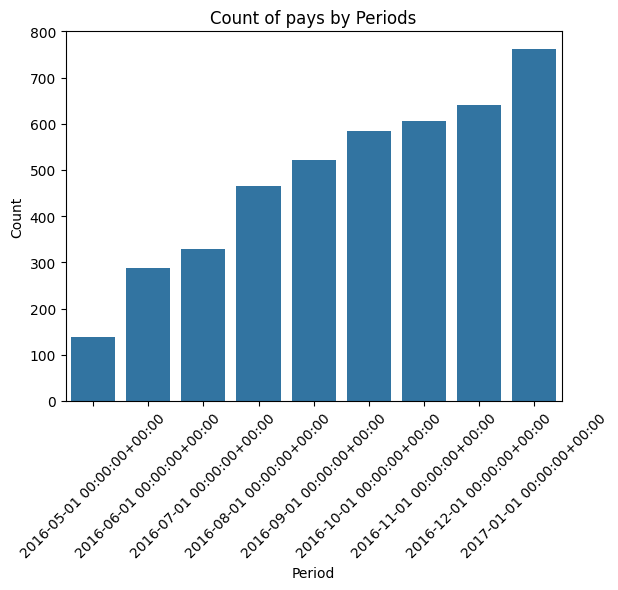

In [392]:
#count of pays by time
sns.barplot(df.groupby("payment_period")["price"].count())
plt.xlabel("Period")
plt.title("Count of pays by Periods")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [393]:
df["userid"].value_counts()

userid
8f24dddcc97c98be4515    9
44d22c57c714e2b16fae    9
8e0f0538e74f227369c8    9
409ad2cf7953b7dfda87    9
449b1e22474c133187b6    9
                       ..
91a128f                 1
91663cd5                1
913f4e91cd3646236ca9    1
9135b71e                1
4046e411                1
Name: count, Length: 1442, dtype: int64

## 2. Retention Rate

In [394]:
df = df.sort_values(["userid", "payment_date"]).assign(row_num = lambda x:
    x.groupby("userid").cumcount() + 1)

first_pay = df[df["row_num"] == 1][["userid", "payment_period"]]


In [395]:
df = df.merge(first_pay, how = "left", suffixes=("", "_first"), on = "userid")

In [396]:
df

,index,payment_date,userid,price,payment_period,row_num,payment_period_first
0,0,2016-08-10 00:00:00+00:00,0014163a53056db3f10e,5000,2016-08-01 00:00:00+00:00,1,2016-08-01 00:00:00+00:00
1,1,2016-09-10 00:00:00+00:00,0014163a53056db3f10e,5000,2016-09-01 00:00:00+00:00,2,2016-08-01 00:00:00+00:00
2,2,2016-10-10 00:00:00+00:00,0014163a53056db3f10e,5000,2016-10-01 00:00:00+00:00,3,2016-08-01 00:00:00+00:00
3,3,2016-05-18 00:00:00+00:00,00164e47967b306239e8,5000,2016-05-01 00:00:00+00:00,1,2016-05-01 00:00:00+00:00
4,4,2016-06-07 00:00:00+00:00,0016e5b445a29e9cbfcc,5000,2016-06-01 00:00:00+00:00,1,2016-06-01 00:00:00+00:00
...,...,...,...,...,...,...,...
4329,4994,2016-11-21 00:00:00+00:00,923200eccb469fc2c4a8,5000,2016-11-01 00:00:00+00:00,6,2016-06-01 00:00:00+00:00
4330,4995,2016-12-21 00:00:00+00:00,923200eccb469fc2c4a8,5000,2016-12-01 00:00:00+00:00,7,2016-06-01 00:00:00+00:00
4331,4996,2016-09-14 00:00:00+00:00,92460443,5000,2016-09-01 00:00:00+00:00,1,2016-09-01 00:00:00+00:00
4332,4997,2016-12-22 00:00:00+00:00,9247f0e61504f112ead4,5000,2016-12-01 00:00:00+00:00,1,2016-12-01 00:00:00+00:00


In [397]:
cohort_counts = df.groupby(["payment_period_first", "payment_period" ])["userid"].nunique().unstack()
cohort_sizes = cohort_counts.apply(lambda row: row.dropna().iloc[0], axis=1)

In [398]:
cohort_counts

payment_period,2016-05-01 00:00:00+00:00,2016-06-01 00:00:00+00:00,2016-07-01 00:00:00+00:00,2016-08-01 00:00:00+00:00,2016-09-01 00:00:00+00:00,2016-10-01 00:00:00+00:00,2016-11-01 00:00:00+00:00,2016-12-01 00:00:00+00:00,2017-01-01 00:00:00+00:00
payment_period_first,,,,,,,,,
2016-05-01 00:00:00+00:00,138.0,91.0,85.0,83.0,77.0,75.0,71.0,65.0,62.0
2016-06-01 00:00:00+00:00,NaN,196.0,107.0,100.0,92.0,89.0,86.0,84.0,80.0
2016-07-01 00:00:00+00:00,NaN,NaN,136.0,84.0,79.0,74.0,71.0,67.0,65.0
2016-08-01 00:00:00+00:00,NaN,NaN,NaN,199.0,106.0,101.0,93.0,86.0,83.0
2016-09-01 00:00:00+00:00,NaN,NaN,NaN,NaN,168.0,70.0,63.0,58.0,54.0
2016-10-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,175.0,94.0,88.0,83.0
2016-11-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,129.0,80.0,77.0
2016-12-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.0,69.0
2017-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,189.0


In [399]:
cohort_sizes

payment_period_first
2016-05-01 00:00:00+00:00    138.0
2016-06-01 00:00:00+00:00    196.0
2016-07-01 00:00:00+00:00    136.0
2016-08-01 00:00:00+00:00    199.0
2016-09-01 00:00:00+00:00    168.0
2016-10-01 00:00:00+00:00    175.0
2016-11-01 00:00:00+00:00    129.0
2016-12-01 00:00:00+00:00    112.0
2017-01-01 00:00:00+00:00    189.0
dtype: float64

In [400]:
retention = cohort_counts.divide(cohort_sizes, axis=0)

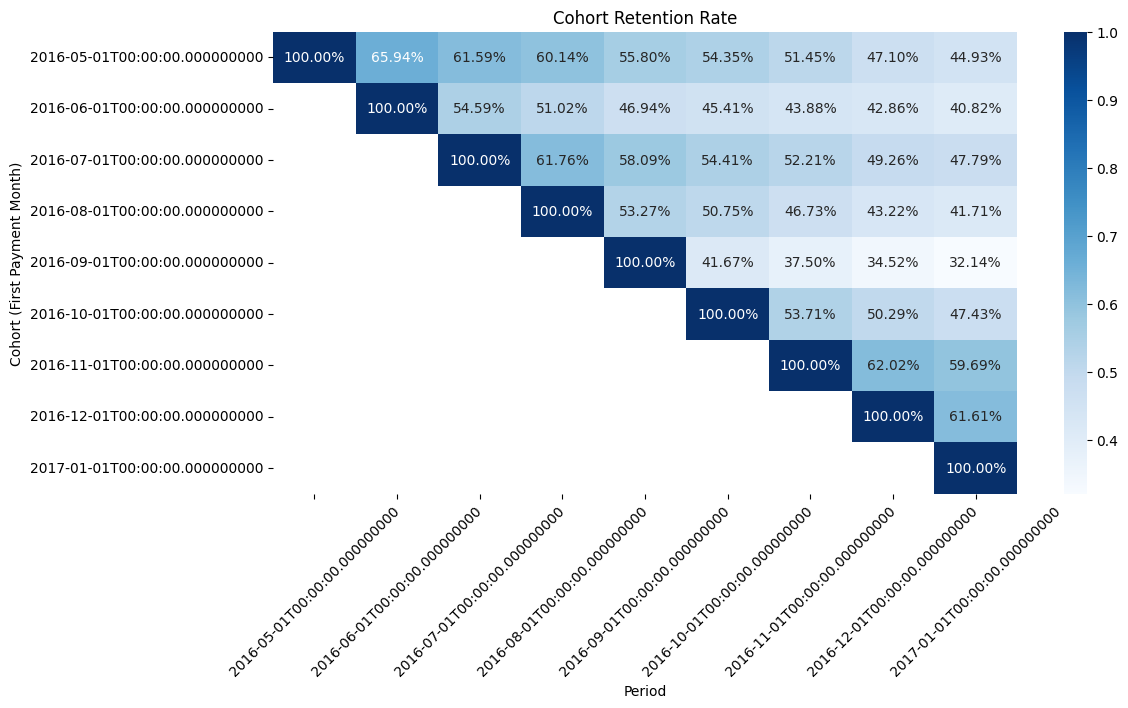

In [401]:
plt.figure(figsize=(12, 6))
sns.heatmap(retention, annot=True, fmt=".2%", cmap="Blues", cbar=True)
plt.title("Cohort Retention Rate")
plt.ylabel("Cohort (First Payment Month)")
plt.xlabel("Period")
plt.xticks(rotation=45)
plt.show()

### 🔍 Key Observations

1. Sharp Drop After First Month
Most cohorts show a noticeable decline in retention after the first month

📉 Implication: A significant portion of users drop off early — this may indicate:

Weak onboarding

Lack of perceived value

No incentive to stay subscribed

2. Retention Stabilizes After 3–4 Months
Many cohorts that survive the first 3 months tend to level off:

e.g., August cohort retains ~41–47% users between month 4 to month 6.

✅ Implication: If a user stays past 3 months, they’re more likely to continue long-term — this is a critical retention milestone.



## 3. Customer Lifetime Value (LTV)

In [402]:
ltv = df.groupby("userid")["price"].sum()

Mean and Median

In [403]:
print("LTV_mean -",np.mean(ltv))
print("LTV_median -",np.median(ltv))

LTV_mean - 15027.739251040222
LTV_median - 5000.0


→ This means over 50% of users only made one payment.

#### Histplot Distribution of Customer Lifetime Value

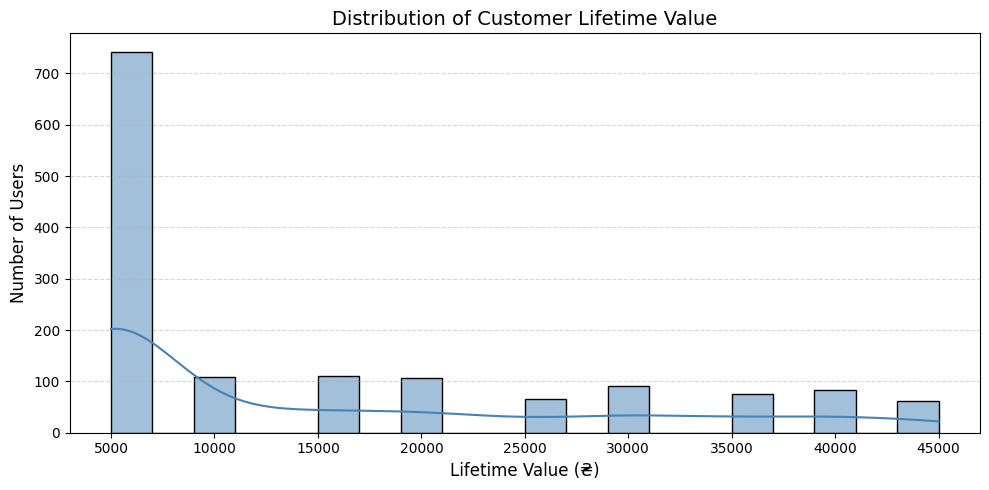

In [404]:
# Побудова графіку
plt.figure(figsize=(10, 5))
sns.histplot(ltv, bins=20, kde=True, color="steelblue", edgecolor="black")

plt.title("Distribution of Customer Lifetime Value", fontsize=14)
plt.xlabel("Lifetime Value (₴)", fontsize=12)
plt.ylabel("Number of Users", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 🔍 Observations:

1. Highly Skewed Distribution
The distribution is right-skewed (positively skewed): most users are clustered at the lower end.

The highest peak is at ₴5,000, indicating a large portion of users subscribed only once.

2. Small Group of High-Value Users
There’s a long tail of users with higher LTVs (₴10,000 to ₴45,000)

These users significantly raise the average, which is 3x higher than the median — showing presence of a high-value minority.

📌 Implication: a small % of loyal users bring in a large share of revenue.


🎯 Recommendations:
Identify high-LTV users:

Who are they? When did they join? Can you replicate that segment?

Re-engage low-LTV users:

Try onboarding improvements, discounts on month 2, or bundle offers.

Consider tiered pricing:

Offer incentives for longer commitments upfront (e.g. 3-month plan).

## Cohort-based LTV

In [405]:
df["months_since"] = (pd.to_datetime(df["payment_period"]).dt.to_period("M") - pd.to_datetime(df["payment_period_first"]).dt.to_period("M")).apply(attrgetter("n"))

cohort_revenue = df.groupby(["payment_period_first", "months_since"])["price"].sum()
cohort_sizes = df[df["months_since"] == 0].groupby("payment_period_first")["userid"].nunique()

cohort_ltv = cohort_revenue.unstack().divide(cohort_sizes, axis=0).round(0)

C:\Users\nabak\AppData\Local\Temp\ipykernel_11688\2011795481.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["months_since"] = (pd.to_datetime(df["payment_period"]).dt.to_period("M") - pd.to_datetime(df["payment_period_first"]).dt.to_period("M")).apply(attrgetter("n"))
C:\Users\nabak\AppData\Local\Temp\ipykernel_11688\2011795481.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["months_since"] = (pd.to_datetime(df["payment_period"]).dt.to_period("M") - pd.to_datetime(df["payment_period_first"]).dt.to_period("M")).apply(attrgetter("n"))


In [406]:
cohort_ltv

months_since,0,1,2,3,4,5,6,7,8
payment_period_first,,,,,,,,,
2016-05-01 00:00:00+00:00,5000.0,3297.0,3080.0,3007.0,2790.0,2717.0,2572.0,2355.0,2246.0
2016-06-01 00:00:00+00:00,5000.0,2730.0,2551.0,2347.0,2270.0,2194.0,2143.0,2041.0,NaN
2016-07-01 00:00:00+00:00,5000.0,3088.0,2904.0,2721.0,2610.0,2463.0,2390.0,NaN,NaN
2016-08-01 00:00:00+00:00,5000.0,2663.0,2538.0,2337.0,2161.0,2085.0,NaN,NaN,NaN
2016-09-01 00:00:00+00:00,5000.0,2083.0,1875.0,1726.0,1607.0,NaN,NaN,NaN,NaN
2016-10-01 00:00:00+00:00,5000.0,2686.0,2514.0,2371.0,NaN,NaN,NaN,NaN,NaN
2016-11-01 00:00:00+00:00,5000.0,3101.0,2984.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-01 00:00:00+00:00,5000.0,3080.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:00:00+00:00,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


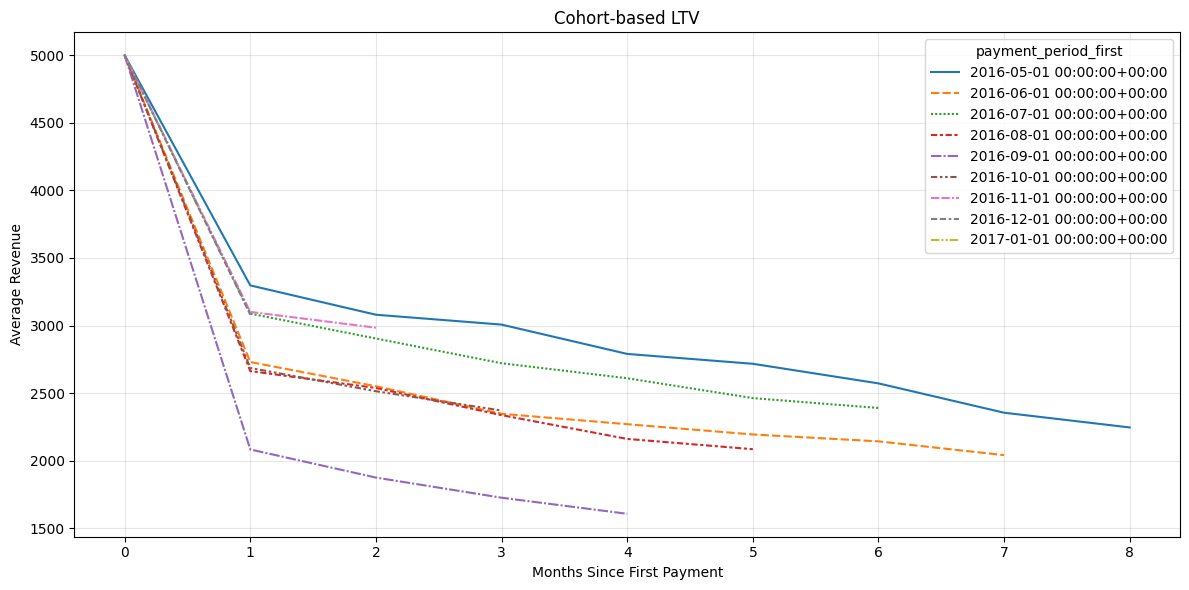

In [407]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=cohort_ltv.T)
plt.title("Cohort-based LTV")
plt.xlabel("Months Since First Payment")
plt.ylabel("Average Revenue")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [408]:
cohort_ltv_cumulative = cohort_ltv.cumsum(axis=1)

In [409]:
cohort_ltv_cumulative

months_since,0,1,2,3,4,5,6,7,8
payment_period_first,,,,,,,,,
2016-05-01 00:00:00+00:00,5000.0,8297.0,11377.0,14384.0,17174.0,19891.0,22463.0,24818.0,27064.0
2016-06-01 00:00:00+00:00,5000.0,7730.0,10281.0,12628.0,14898.0,17092.0,19235.0,21276.0,NaN
2016-07-01 00:00:00+00:00,5000.0,8088.0,10992.0,13713.0,16323.0,18786.0,21176.0,NaN,NaN
2016-08-01 00:00:00+00:00,5000.0,7663.0,10201.0,12538.0,14699.0,16784.0,NaN,NaN,NaN
2016-09-01 00:00:00+00:00,5000.0,7083.0,8958.0,10684.0,12291.0,NaN,NaN,NaN,NaN
2016-10-01 00:00:00+00:00,5000.0,7686.0,10200.0,12571.0,NaN,NaN,NaN,NaN,NaN
2016-11-01 00:00:00+00:00,5000.0,8101.0,11085.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-01 00:00:00+00:00,5000.0,8080.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:00:00+00:00,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


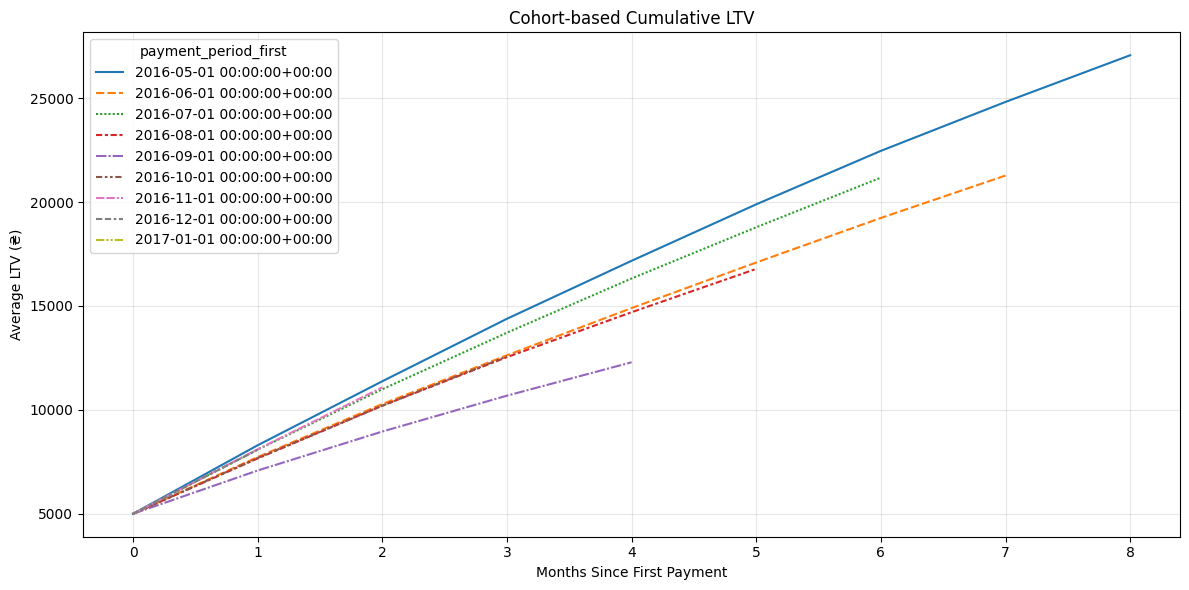

In [410]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=cohort_ltv_cumulative.T)
plt.title("Cohort-based Cumulative LTV")
plt.xlabel("Months Since First Payment")
plt.ylabel("Average LTV (₴)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 🔍 Key Findings
1. Older cohorts generate the highest LTV
2. May 2016 cohort stands out with the highest cumulative LTV, reaching ₴27,065 by month 8.

July 2016 and August 2016 cohorts also show strong long-term performance, with LTV exceeding ₴21,000 by month 6.

3. The September 2016 cohort shows notably lower cumulative LTV compared to earlier cohorts (May–August):

After 4 months, the September cohort reaches approximately ₴12,291, which is significantly below cohorts

The growth rate in cumulative LTV for the September cohort is visibly slower from the start, indicating weaker retention or possibly lower engagement levels from these users.

Recommended Action:

Investigate the specific conditions or changes during September (e.g., marketing campaigns, promotions, product updates).

Compare user demographics, engagement metrics, and feedback from this cohort with stronger-performing cohorts to uncover underlying reasons for weaker retention.

## LTV Forecasting 

Lets make forecast to full year for cohorts that have 3+ live months with Linear Regresion

In [411]:
cohort_ltv_cumulative_filtered = cohort_ltv_cumulative[
    ~cohort_ltv_cumulative.index.isin(
        pd.to_datetime(["2017-01-01", "2016-12-01"]).tz_localize("UTC")
    )
]

In [412]:
cohort_ltv_cumulative.index

DatetimeIndex(['2016-05-01 00:00:00+00:00', '2016-06-01 00:00:00+00:00',
               '2016-07-01 00:00:00+00:00', '2016-08-01 00:00:00+00:00',
               '2016-09-01 00:00:00+00:00', '2016-10-01 00:00:00+00:00',
               '2016-11-01 00:00:00+00:00', '2016-12-01 00:00:00+00:00',
               '2017-01-01 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='payment_period_first', freq=None)

In [ ]:
def forecast_cohort(row, forecast_month=12):
    data = row.dropna()
    X = np.array(data.index).reshape(-1, 1)
    y = data.values

    if len(y) < 2:
        return pd.Series([np.nan] * forecast_month, index=range(forecast_month))

    model = LinearRegression()
    model.fit(X, y)

    start = len(data)
    future_months = np.arange(start, forecast_month).reshape(-1, 1)
    forecast = model.predict(future_months)

    full_forecast = [np.nan] * start + list(forecast)

    return pd.Series(full_forecast, index=range(forecast_month))


In [414]:
cohort_ltv_cumulative_filtered.index = cohort_ltv_cumulative_filtered.index.to_series()#.apply(lambda d: d.date())

cohort_ltv_cumulative_filtered

months_since,0,1,2,3,4,5,6,7,8
payment_period_first,,,,,,,,,
2016-05-01 00:00:00+00:00,5000.0,8297.0,11377.0,14384.0,17174.0,19891.0,22463.0,24818.0,27064.0
2016-06-01 00:00:00+00:00,5000.0,7730.0,10281.0,12628.0,14898.0,17092.0,19235.0,21276.0,NaN
2016-07-01 00:00:00+00:00,5000.0,8088.0,10992.0,13713.0,16323.0,18786.0,21176.0,NaN,NaN
2016-08-01 00:00:00+00:00,5000.0,7663.0,10201.0,12538.0,14699.0,16784.0,NaN,NaN,NaN
2016-09-01 00:00:00+00:00,5000.0,7083.0,8958.0,10684.0,12291.0,NaN,NaN,NaN,NaN
2016-10-01 00:00:00+00:00,5000.0,7686.0,10200.0,12571.0,NaN,NaN,NaN,NaN,NaN
2016-11-01 00:00:00+00:00,5000.0,8101.0,11085.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
forecasted_ltv = cohort_ltv_cumulative_filtered.apply(forecast_cohort, axis=1)

In [420]:
forecasted_ltv = cohort_ltv_cumulative_filtered.combine_first(forecasted_ltv)
forecasted_ltv

,0,1,2,3,4,5,6,7,8,9,10,11
payment_period_first,,,,,,,,,,,,
2016-05-01 00:00:00+00:00,5000.0,8297.0,11377.0,14384.0,17174.0,19891.0,22463.0,24818.000000,27064.000000,30510.166667,33268.466667,36026.766667
2016-06-01 00:00:00+00:00,5000.0,7730.0,10281.0,12628.0,14898.0,17092.0,19235.0,21276.000000,23918.928571,26230.357143,28541.785714,30853.214286
2016-07-01 00:00:00+00:00,5000.0,8088.0,10992.0,13713.0,16323.0,18786.0,21176.0,24190.428571,26878.107143,29565.785714,32253.464286,34941.142857
2016-08-01 00:00:00+00:00,5000.0,7663.0,10201.0,12538.0,14699.0,16784.0,19384.0,21737.285714,24090.571429,26443.857143,28797.142857,31150.428571
2016-09-01 00:00:00+00:00,5000.0,7083.0,8958.0,10684.0,12291.0,14258.1,16076.4,17894.700000,19713.000000,21531.300000,23349.600000,25167.900000
2016-10-01 00:00:00+00:00,5000.0,7686.0,10200.0,12571.0,15171.0,17693.7,20216.4,22739.100000,25261.800000,27784.500000,30307.200000,32829.900000
2016-11-01 00:00:00+00:00,5000.0,8101.0,11085.0,14147.0,17189.5,20232.0,23274.5,26317.000000,29359.500000,32402.000000,35444.500000,38487.000000


C:\Users\nabak\AppData\Local\Temp\ipykernel_11688\1439265518.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab10", len(cohorts))  # Або "Set1", "Dark2", "Paired"


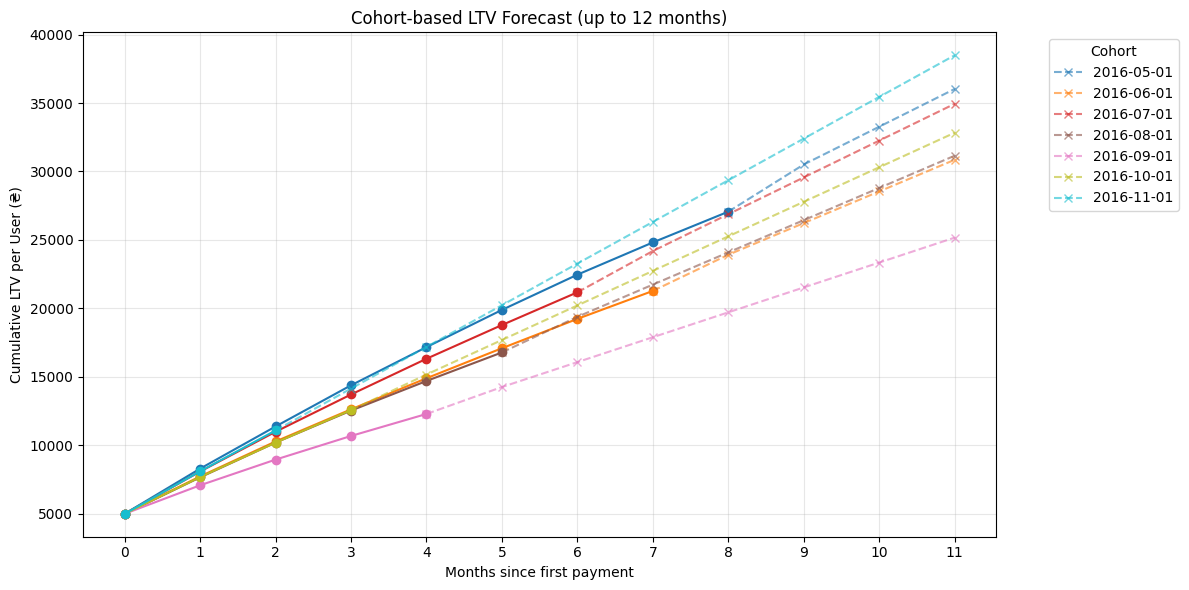

In [ ]:
plt.figure(figsize=(12, 6))

cohorts = list(cohort_ltv_cumulative_filtered.index)
colors = cm.get_cmap("tab10", len(cohorts)) 

for i, cohort in enumerate(cohorts):
    actual = cohort_ltv_cumulative_filtered.loc[cohort].dropna()
    cohort_key = pd.to_datetime(cohort)
    forecast = forecasted_ltv.loc[cohort_key]

    last_actual_month = actual.index[-1]
    cohort_label = cohort.strftime('%Y-%m-%d')
    color = colors(i)

    # Фактична частина (суцільна)
    plt.plot(
        actual.index, actual,
        linestyle='-', marker='o', color=color
    )

    # Прогнозована частина (пунктирна)
    forecast_months = range(last_actual_month, 12)
    plt.plot(
        forecast_months, forecast[last_actual_month:],
        linestyle='--', marker='x', color=color, alpha=0.6,
        label=cohort_label  # 👈 додано до легенди
    )

plt.legend(title="Cohort", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel("Months since first payment")
plt.ylabel("Cumulative LTV per User (₴)")
plt.title("Cohort-based LTV Forecast (up to 12 months)")
plt.grid(alpha=0.3)
plt.xticks(range(12))
plt.tight_layout()
plt.show()

## 🔍 Key Observations:
1. 📈 Strong Growth Across Cohorts
All cohorts show a consistent upward trend in LTV.

Early cohorts like May, June, and July 2016 are projected to reach ₴30,000–₴36,000 by month 12.

2. 🥇 Best Performing Cohort: November 2016
Despite being one of the most recent cohorts, November 2016 has the steepest growth rate.

It is forecasted to reach nearly ₴38,500 per user by month 12 — the highest among all.

📌 Interpretation: Something improved in acquisition, product experience, or pricing that positively affected this cohort.

3. ⚖️ Moderate Performers: June–October Cohorts
Cohorts like August, September, and October 2016 follow consistent but slightly flatter growth curves.

They are projected to reach ₴31,000–₴35,000 by month 12.

September 2016 remains the lowest performer in this group, reaching only ~₴25,000 by month 12.

📌 Interpretation: These users likely had lower retention or engagement rates. September may reflect a weaker campaign or product change.